# Elon Musk Tweets

Project to analyze Elon Musk's tweets between 2020 an 2023. The goal is to show the people's attitude and emotions towards Elon Musk's tweets. The data is collected from Twitter using snscrape scraper. One Elon's tweet and comments to it are taken every single day. The data is then preprocessed, tokenized and lemmatized. The sentiment analysis is performed using NLTK library. We also use text2emotion library to analyze the emotions in the comments and WordCloud to visualize the most frequent words in the comments.

In [ ]:
import pandas as pd
import snscrape.modules.twitter as sntwitter
import datetime
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import text2emotion as te
from wordcloud import WordCloud

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')

In [69]:
# Get specyfied number of tweets from specified user between specified dates
def get_user_tweets(username, num_tweets, start_date, end_date):
    tweets = []
    
    for tweet in sntwitter.TwitterSearchScraper(search(username=username, since=start_date, until=end_date, retweet="y", replies="y")).get_items():
        tweets.append(tweet)
        if len(tweets) == num_tweets:
            break
    
    return tweets

# Get specyfic number of comments from specified tweet
def get_tweet_comments(username, tweet_id, num_comments):
    comments = []
    for comment in sntwitter.TwitterSearchScraper(f"to:{username} conversation_id:{tweet_id}").get_items():
        comments.append([comment.date, comment.rawContent])
        if len(comments) == num_comments:
            break
    return comments

# Function wich returns query for snscrape
def search(text="",username="",since="",until="",retweet="",replies=""): 
    q = text 
    if username!='': 
        q += f" from:{username}"
    if until=='': 
        until = datetime.datetime.strftime(datetime.date.today(), '%Y-%m-%d') 
    q += f" until:{until}" 
    if since=='': 
        since = datetime.datetime.strftime(datetime.datetime.strptime(until, '%Y-%m-%d') - datetime.timedelta(days=7), '%Y-%m-%d') 
    q += f" since:{since}" 
    if retweet == 'y': 
        q += f" exclude:retweets" 
    if replies == 'y': 
        q += f" exclude:replies" 
    
    return q 

In [ ]:
# Getting tweets from Elon Musk and comments for them from 2020-01-01 to 2023-01-01

tweets = []
comments_to_tweet = []

start_date = datetime.datetime(2020, 1, 1)
end_date = datetime.datetime(2023, 1, 1)

current_date = start_date
while current_date <= end_date:
    current_date_str = current_date.strftime('%Y-%m-%d')
    tomorrow_str = (current_date + datetime.timedelta(days=1)).strftime('%Y-%m-%d')
    tweet = get_user_tweets('elonmusk', 1, current_date_str, tomorrow_str)
    if len(tweet) > 0:
        id = tweet[0].id
        url = tweet[0].url
        tweets.append([tweet[0].date, tweet[0].rawContent, id, url])
        comments = get_tweet_comments('elonmusk', id, url, tweet[0].date, 100)
        comments_to_tweet.extend(comments)
    current_date += datetime.timedelta(days=1)

In [ ]:
# Saving tweets to csv files
tweets_df = pd.DataFrame(tweets, columns=['date', 'content', 'id', 'url'])
tweets_df.to_csv('elonmusk_tweets.csv', index=False)

In [ ]:
# Saving comments to csv files
comments_df = pd.DataFrame(comments_to_tweet, columns=['date', 'content', 'tweet_id', 'tweet_url', 'tweet_date', 'url'])
comments_df.to_csv('elonmusk_comments.csv', index=False)

In [3]:
# Reading tweets from csv file and printing number of tweets
df = pd.read_csv('elonmusk_comments.csv')
df.shape

(42960, 6)

In [4]:
# Printing first 5 rows of tweets
df['tweet_date'] = df['tweet_date'].apply(lambda x: x.split(' ')[0])
df.head()

,date,content,tweet_id,tweet_url,tweet_date,url
0,2022-04-10 20:15:55+00:00,@elonmusk Writing a paper on forward contamina...,1212264717617639424,https://twitter.com/elonmusk/status/1212264717...,2020-01-01,https://twitter.com/sheryleekathrne/status/151...
1,2021-01-08 00:24:51+00:00,"@elonmusk For Elon Musk, dont worry you will b...",1212264717617639424,https://twitter.com/elonmusk/status/1212264717...,2020-01-01,https://twitter.com/interpolasyon/status/13473...
2,2020-03-24 23:38:43+00:00,@elonmusk Awesome email me,1212264717617639424,https://twitter.com/elonmusk/status/1212264717...,2020-01-01,https://twitter.com/LeviladdB/status/124259673...
3,2020-03-07 18:31:30+00:00,@elonmusk Seks,1212264717617639424,https://twitter.com/elonmusk/status/1212264717...,2020-01-01,https://twitter.com/maybeucantry/status/123635...
4,2020-01-24 21:01:15+00:00,@elonmusk Question are you by any chance a gamer?,1212264717617639424,https://twitter.com/elonmusk/status/1212264717...,2020-01-01,https://twitter.com/Pocketguy14/status/1220813...


In [5]:
# Removing duplicates, tweets with links (scam in most cases) and empty content
df = df.drop_duplicates(subset=['content'])
df = df[~df['content'].str.contains('@@@@@@@@')]
df = df[~df['content'].str.contains('http://')]
df = df[~df['content'].str.contains('https://')]
df = df.dropna()
df.shape

(34068, 6)

In [6]:
# Setting stopwords and adding Elon's username to them 
stopwords_list = stopwords.words('english')
stopwords_list.extend(['elonmusk'])

# Tokenizing, lemmatizing and removing stopwords from tweets
def tokenize_and_lemmatize(x):
    words = nltk.word_tokenize(x)
    words = [word.lower() for word in words if word.isalpha()]
    words = [word for word in words if word not in stopwords_list]
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    return words

df['content'] = df['content'].apply(lambda x: tokenize_and_lemmatize(x))

In [7]:
# Calculating sentiment for each tweet
sid = SentimentIntensityAnalyzer()

df['sentiment'] = df['content'].apply(lambda x: sid.polarity_scores(' '.join(x))['compound'])

In [8]:
# Getting minimum and maximum sentiment
max_sentiment = df['sentiment'].max()
min_sentiment = df['sentiment'].min()
print(max_sentiment, min_sentiment)

0.9918 -0.9991


In [9]:
# Printing 5 most positive comments
most_postive = df.sort_values(by=['sentiment'], ascending=False).head(5)
for i in range(most_postive.shape[0]):
    print(most_postive.iloc[i, 1])
    print('')

['hi', 'nice', 'good', 'congratulation', 'men', 'good', 'luck', 'next', 'time', 'doll', 'men', 'support', 'always', 'first', 'time', 'see', 'like', 'congratulation', 'men', 'proud', 'japan', 'fan', 'good', 'luck', 'handsome', 'men', 'world', 'good', 'luck']

['hola', 'please', 'negotiate', 'contract', 'assemblyline', 'worker', 'happier', 'happier', 'car', 'better', 'trouble', 'free', 'sell', 'amount', 'percentage', 'corporate', 'profit', 'win', 'win', 'win', 'win', 'win']

['bet', 'also', 'love', 'good', 'thing', 'love', 'delicious', 'food', 'love', 'beauty', 'love', 'happiness']

['read', 'interesting', 'post', 'tube', 'last', 'night', 'closed', 'poll', 'q', 'relationship', 'two', 'dynamic', 'interdependent', 'white', 'people', 'privilege', 'privilege', 'whiteprivilege', 'discrimination', 'youtube', 'kid', 'know', 'nothing', 'discrimination', 'racism', 'zero', 'america', 'abundant', 'free', 'money', 'education', 'first', 'taxpayer', 'pay', 'every', 'dollar', 'social', 'svc', 'program'

In [10]:
# Printing 5 most negative comments
most_negative = df.sort_values(by=['sentiment'], ascending=True).head(5)
for i in range(most_negative.shape[0]):
    print(most_negative.iloc[i, 1])
    print('')

['test', 'cunt', 'cunt', 'cunt', 'cunt', 'cunt', 'cunt', 'cunt', 'cunt', 'cunt', 'cunt', 'cunt', 'cunt', 'cunt', 'cunt', 'cunt', 'cunt', 'cunt', 'cunt', 'cunt', 'cunt', 'cunt', 'cunt', 'cunt', 'cunt', 'cunt', 'cunt', 'cunt', 'cunt', 'cunt', 'cunt', 'cunt', 'cunt', 'cunt', 'cunt', 'cunt', 'cunt', 'cunt', 'cunt', 'cunt', 'cunt', 'cunt', 'cunt']

['fire', 'fauci', 'fire', 'fauci', 'fire', 'fauci', 'fire', 'fauci', 'fire', 'fauci', 'fire', 'fauci', 'fire', 'fauci', 'fire', 'fauci', 'fire', 'fauci', 'fire', 'fauci', 'fire', 'fauci', 'fire', 'fauci', 'fire', 'fauci', 'fire', 'fauci']

['democrat', 'started', 'slavery', 'van', 'buren', 'killing', 'indian', 'around', 'country', 'every', 'american', 'soldier', 'killed', 'battle', 'democratic', 'war', 'party', 'intentionally', 'extended', 'war', 'vietnam', 'economy', 'fallen', 'every', 'dem', 'regime']

['flcnhvy', 'medium', 'continued', 'tesla', 'hate', 'tired', 'killer', 'killer', 'killer', 'ice', 'killer', 'collectively', 'every', 'new', 'ev'

In [11]:
# Grouping tweets by date and calculating mean sentiment for each day
daily_sentiment_df = df.groupby('tweet_id')
daily_sentiment_df = daily_sentiment_df.agg({'sentiment': 'mean', 'tweet_date': 'first'})
daily_sentiment_df = daily_sentiment_df.sort_values(by=['tweet_date'])
daily_sentiment_df.head()

,sentiment,tweet_date
tweet_id,,
1212264717617639424,0.219767,2020-01-01
1213620051770671104,0.125058,2020-01-05
1214483582363693057,0.201341,2020-01-07
1214956305808527361,0.219007,2020-01-08
1215212801876090880,0.140033,2020-01-09


In [12]:
# 5 most positive days
daily_sentiment_df.sort_values(by=['sentiment'], ascending=False).head(5)

,sentiment,tweet_date
tweet_id,,
1482495353542754308,0.7650,2022-01-15
1372688191803768840,0.6486,2021-03-18
1406708267141648384,0.5955,2021-06-20
1431867661164687360,0.5794,2021-08-29
1508983155205804038,0.5524,2022-03-30


In [13]:
# One of the most positive tweets
tweets_df = pd.read_csv('elonmusk_tweets.csv')
t = tweets_df[tweets_df['id'] == 1482495353542754308]
print(t.content)


438    https://t.co/6qGivJoQf0
Name: content, dtype: object


In [14]:
# One of the most positive tweets
t = tweets_df[tweets_df['id'] == 1372688191803768840]
print(t.content)


260    First Super Heavy Booster https://t.co/0K5QPsEbbt
Name: content, dtype: object


In [15]:
# 5 most negative days
daily_sentiment_df.sort_values(by=['sentiment'], ascending=True).head(5)

,sentiment,tweet_date
tweet_id,,
1436086743720251394,-0.77830,2021-09-09
1457984721892352002,-0.59940,2021-11-09
1531733235625074688,-0.58590,2022-05-31
1383548841438236674,-0.44035,2021-04-17
1294922167310663681,-0.39820,2020-08-16


In [16]:
# One of the most negative tweets
pd.set_option('display.max_colwidth', None)
t = tweets_df[tweets_df['id'] == 1436086743720251394]
print(t.content)

366    Tesla Model S Plaid just set official world speed record for a production electric car at Nurburgring. Completely unmodified, directly from factory. https://t.co/AaiFtfW5Ht
Name: content, dtype: object


In [17]:
# One of the most negative tweets
t = tweets_df[tweets_df['id'] == 1457984721892352002]
print(t.content)

397    I have all their albums https://t.co/OwQaSJADDE
Name: content, dtype: object


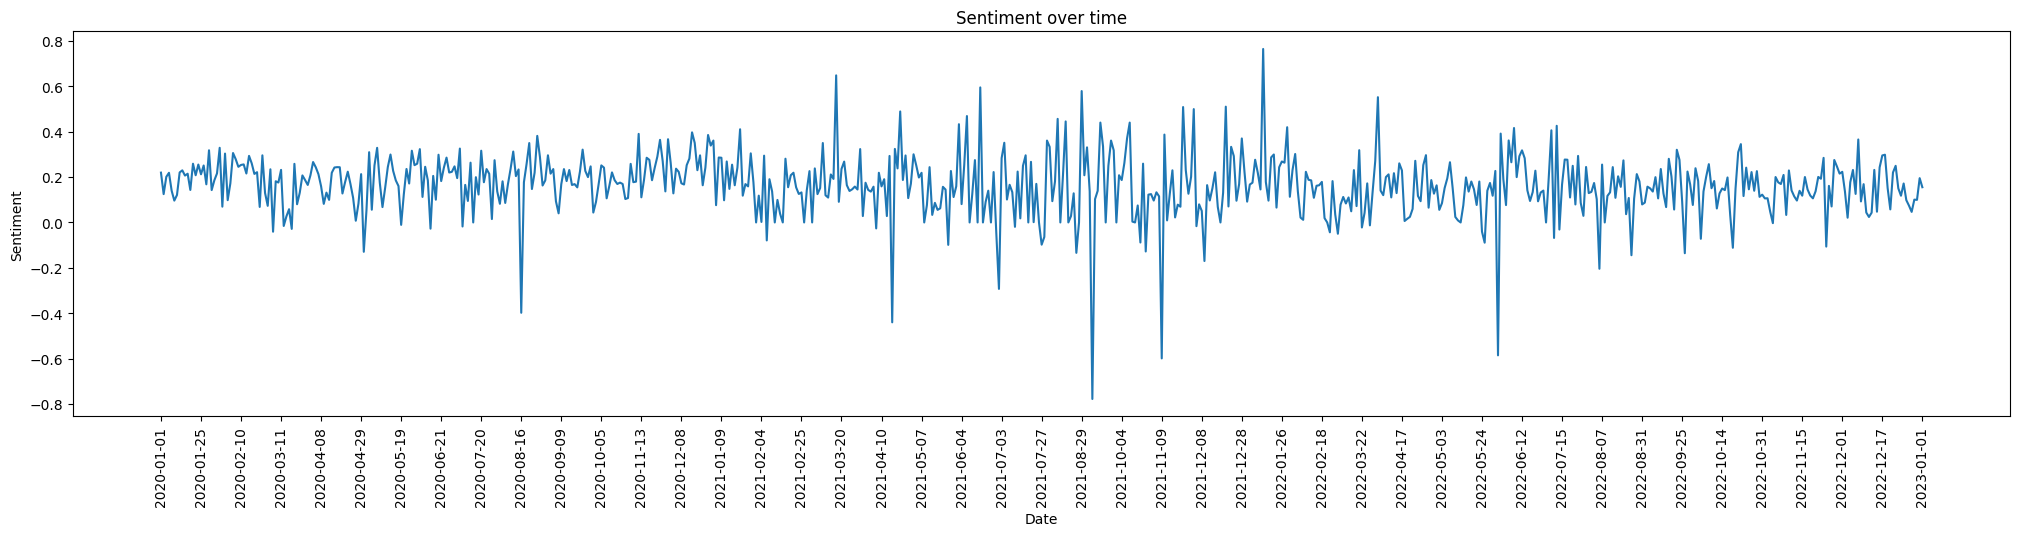

In [18]:
# Plotting sentiment over time
plt.figure(figsize=(25, 5))
plt.plot(daily_sentiment_df['tweet_date'], daily_sentiment_df['sentiment'])
plt.xlabel('Date')
plt.ylabel('Sentiment')
plt.title('Sentiment over time')
plt.xticks(daily_sentiment_df['tweet_date'][::15], rotation=90)
plt.show()

In [19]:
# Day with the most negative sentiment
print(daily_sentiment_df[daily_sentiment_df['sentiment'] == daily_sentiment_df['sentiment'].min()])

                     sentiment  tweet_date
tweet_id                                  
1436086743720251394    -0.7783  2021-09-09


In [20]:
# Day with the most positive sentiment
print(daily_sentiment_df[daily_sentiment_df['sentiment'] == daily_sentiment_df['sentiment'].max()])

                     sentiment  tweet_date
tweet_id                                  
1482495353542754308      0.765  2022-01-15


In [25]:
# Negativity, neutrality and positivity of all tweets
all_words = []
for i in range(df.shape[0]):
    all_words.extend(df.iloc[i, 1])
sid = SentimentIntensityAnalyzer()
scores = sid.polarity_scores(' '.join(all_words))
print(scores)

{'neg': 0.1, 'neu': 0.636, 'pos': 0.264, 'compound': 1.0}


In [24]:
# Emotions of all tweets
print(te.get_emotion(' '.join(all_words)))

{'Happy': 0.17, 'Angry': 0.06, 'Surprise': 0.17, 'Sad': 0.22, 'Fear': 0.37}


In [26]:
# Emotions of each tweet
emotion_df = df.copy()
emotion_df['emotion'] = emotion_df['content'].apply(lambda x: te.get_emotion(' '.join(x)))

emotion_df.head()

,date,content,tweet_id,tweet_url,tweet_date,url,sentiment,emotion
0,2022-04-10 20:15:55+00:00,"[writing, paper, forward, contamination, ntflx, doc, gloss, trash, mar, opportunity, present, comment, space, x, research, available, plan, reduce, risk, prediction, made, mathematics, pas, moral, judgement]",1212264717617639424,https://twitter.com/elonmusk/status/1212264717617639424,2020-01-01,https://twitter.com/sheryleekathrne/status/1513249438059225089,0.1779,"{'Happy': 0.2, 'Angry': 0.2, 'Surprise': 0.0, 'Sad': 0.4, 'Fear': 0.2}"
1,2021-01-08 00:24:51+00:00,"[elon, musk, dont, worry, successful, richest, person, trust]",1212264717617639424,https://twitter.com/elonmusk/status/1212264717617639424,2020-01-01,https://twitter.com/interpolasyon/status/1347338443529994242,-0.0366,"{'Happy': 0.0, 'Angry': 0.0, 'Surprise': 0.0, 'Sad': 0.5, 'Fear': 0.5}"
2,2020-03-24 23:38:43+00:00,"[awesome, email]",1212264717617639424,https://twitter.com/elonmusk/status/1212264717617639424,2020-01-01,https://twitter.com/LeviladdB/status/1242596738374008839,0.6249,"{'Happy': 0.0, 'Angry': 0.0, 'Surprise': 1.0, 'Sad': 0.0, 'Fear': 0.0}"
3,2020-03-07 18:31:30+00:00,[seks],1212264717617639424,https://twitter.com/elonmusk/status/1212264717617639424,2020-01-01,https://twitter.com/maybeucantry/status/1236358833259327488,0.0000,"{'Happy': 0, 'Angry': 0, 'Surprise': 0, 'Sad': 0, 'Fear': 0}"
4,2020-01-24 21:01:15+00:00,"[question, chance, gamer]",1212264717617639424,https://twitter.com/elonmusk/status/1212264717617639424,2020-01-01,https://twitter.com/Pocketguy14/status/1220813840285175808,0.2500,"{'Happy': 0.0, 'Angry': 0.0, 'Surprise': 0.0, 'Sad': 0.0, 'Fear': 1.0}"


In [27]:
# Saving emotions to csv file
emotion_df.to_csv('elonmusk_emotion.csv', index=False)

In [28]:
# Splitting emotions to separate columns
emotion_df['happy'] = emotion_df['emotion'].apply(lambda x: x['Happy'])
emotion_df['angry'] = emotion_df['emotion'].apply(lambda x: x['Angry'])
emotion_df['surprise'] = emotion_df['emotion'].apply(lambda x: x['Surprise'])
emotion_df['sad'] = emotion_df['emotion'].apply(lambda x: x['Sad'])
emotion_df['fear'] = emotion_df['emotion'].apply(lambda x: x['Fear'])

In [29]:
# Grouping emotions by date and calculating mean for each day
gruped_emotion_df = emotion_df.groupby('tweet_id')
gruped_emotion_df = gruped_emotion_df.agg({'happy': 'mean', 'angry': 'mean', 'surprise': 'mean', 'sad': 'mean', 'fear': 'mean', 'tweet_date': 'first'})
gruped_emotion_df = gruped_emotion_df.sort_values(by=['tweet_date'])

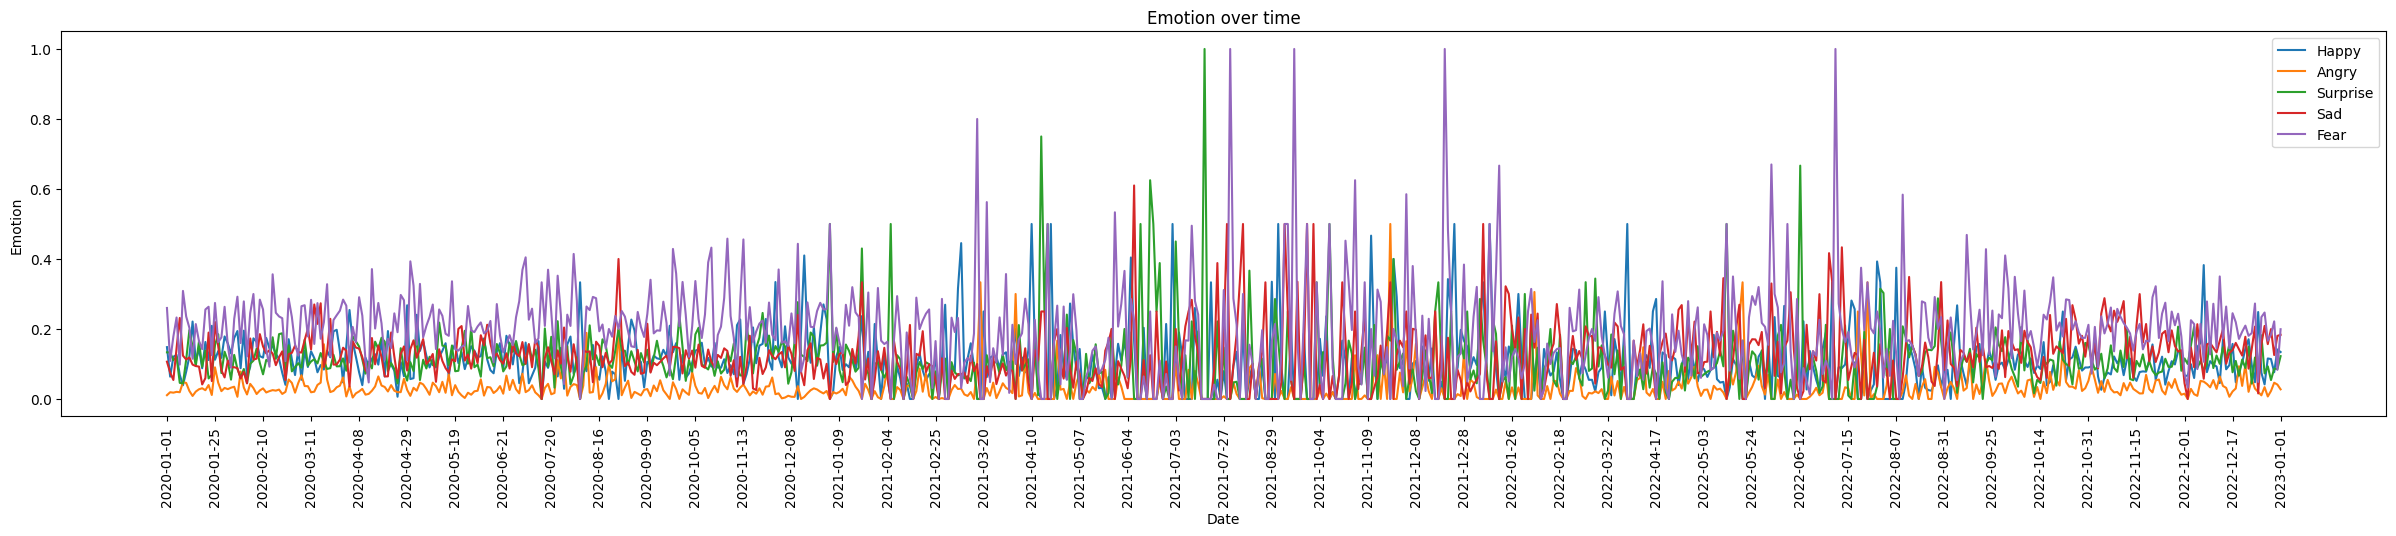

In [36]:
# Plotting emotions over time
plt.figure(figsize=(30, 5))
plt.plot(gruped_emotion_df['tweet_date'], gruped_emotion_df['happy'], label='Happy')
plt.plot(gruped_emotion_df['tweet_date'], gruped_emotion_df['angry'], label='Angry')
plt.plot(gruped_emotion_df['tweet_date'], gruped_emotion_df['surprise'], label='Surprise')
plt.plot(gruped_emotion_df['tweet_date'], gruped_emotion_df['sad'], label='Sad')
plt.plot(gruped_emotion_df['tweet_date'], gruped_emotion_df['fear'], label='Fear')
plt.xlabel('Date')
plt.ylabel('Emotion')
plt.title('Emotion over time')
plt.xticks(gruped_emotion_df['tweet_date'][::15], rotation=90)
plt.legend()
plt.show()

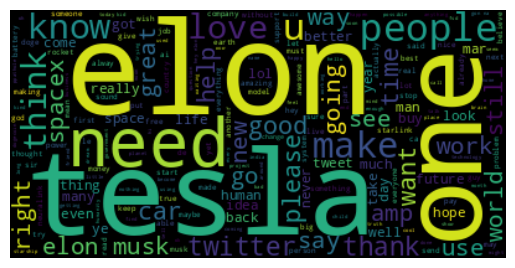

In [38]:
# Most common words in tweets
wordcloud = WordCloud().generate(' '.join(all_words))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

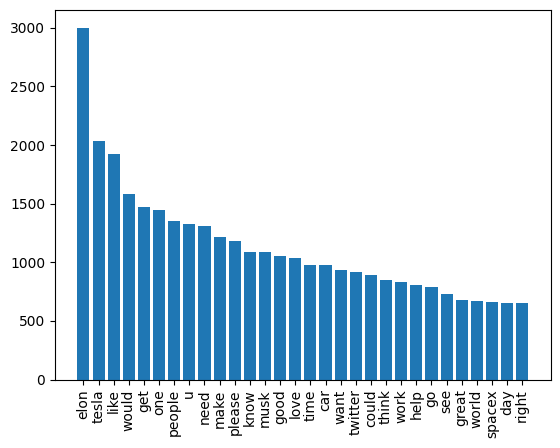

In [42]:
# Amount of most popular words
dictionary = {}
for w in all_words:
    if w in dictionary:
        dictionary[w] += 1
    else:
        dictionary[w] = 1

list_of_tuples = [(k, v) for k, v in dictionary.items()]
list_of_tuples.sort(key=lambda tup: tup[1], reverse=True)

top_10 = list_of_tuples[:30]

plt.bar([t[0] for t in top_10], [t[1] for t in top_10])
plt.xticks(rotation=90)
plt.show()

# Summary

Overall Elon Musk's tweets have positive reception, but they are often controversial and we can see some deviations from the norm. Interesting is fact that fear is the most common emotion in the comments. The most popular words are related to Elon's companies and his projects (Tesla, Twitter, Spacex), but there are also words such as 'people', 'love', 'work', 'great'.

# Links

- https://twitter.com/

- https://www.nltk.org/

- https://pypi.org/project/text2emotion/

- https://pypi.org/project/wordcloud/

- https://pypi.org/project/snscrape/

- https://betterprogramming.pub/how-to-scrape-tweets-with-snscrape-90124ed006af